In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# gpu = 1
import torch

In [2]:
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup,
    AutoTokenizer
)
from peft import get_peft_model, LoraConfig, TaskType, PeftModel, PeftConfig
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import torch.nn.functional as F
from tqdm.auto import tqdm
import shutil
import re
import numpy as np
import random
import matplotlib.pyplot as plt



In [3]:
train_csv      = "/home/work/hhg/train_paragraph_balanced.csv"
test_csv      = "/home/work/.datasets/test.csv"
model_name     = "klue/roberta-base"
batch_size     = 32
learning_rate  = 1e-4
num_epochs     = 30
max_length     = 256
seed           = 42
# %%
checkpoint = "stopword_okt"
print(f"Checkpoint directory: {checkpoint}")

Checkpoint directory: stopword_okt


In [4]:
from konlpy.tag import Okt
import re

# 형태소 분석기 초기화
okt = Okt()

# 불용어 제거 함수
def remove_stopwords_morph(text):
    # 형태소 분석
    tokens = okt.pos(text)

    # 특정 품사 제거
    filtered = [
        t for t, pos in tokens
        if pos not in ['Josa', 'Eomi', 'Conj', 'Exclamation']
    ]

    # 공백 결합
    cleaned_text = " ".join(filtered)

    # 다중 공백 제거
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()

    return cleaned_text


In [5]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(seed)

In [6]:
def clean_text(text):
    text = re.sub(r'\([^)]*\)', ' ', text)
    text = re.sub(r'[ㅎㅜㅠㅡ]+', ' ', text)
    text = re.sub(r'[\r\n]+', ' ', text)  
    text = re.sub(r'[^가-힣a-zA-Z0-9\s.!?]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [7]:
df = pd.read_csv(train_csv)
df = df.dropna(subset=['paragraph_text'])
df['paragraph_text'] = df['paragraph_text'].astype(str)
train_df, val_df = train_test_split(df,test_size=0.3,random_state=seed,stratify=df['generated'])

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,  # 이진 분류니까 2
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
model.config.pad_token_id = model.config.eos_token_id
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=8,
    lora_alpha=16,
    lora_dropout=0.05
)
model = get_peft_model(model, peft_config)
model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(32000, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.05, inplace=False)
                    )
                    (lora_A): Mo

In [11]:
class Dataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length

        # --- 전처리 한 번만 수행 + tqdm bar ---
        self.df = df.copy()
        self.df['processed_text'] = [
            remove_stopwords_morph(clean_text(text)) 
            for text in tqdm(self.df['paragraph_text'], desc="Preprocessing")
        ]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = row['processed_text']
        title = row['title']  # NEW: title 열 추가

        combined_text = f"[TITLE] {title} [SEP] {text}"  # NEW: 타이틀과 본문 결합
        
        inputs = self.tokenizer(
            combined_text,  # NEW: combined_text로 토큰화
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )
        
        item = {key: val.squeeze(0) for key, val in inputs.items()}
        item['generated'] = torch.tensor(row['generated'], dtype=torch.long)
        
        return item


In [12]:
train_dataset = Dataset(train_df, tokenizer, max_length=max_length)
val_dataset   = Dataset(val_df, tokenizer, max_length=max_length)
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader    = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Preprocessing:   0%|          | 0/140996 [00:00<?, ?it/s]

Preprocessing:   0%|          | 0/60428 [00:00<?, ?it/s]

In [12]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
import torch.nn.functional as F

def train(model, loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    all_preds, all_labels, all_probs = [], [], []
    progress_bar = tqdm(loader, desc="Training", leave=False)
    
    for batch in progress_bar:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['generated'].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        logits = outputs.logits
        probs = F.softmax(logits, dim=1)[:, 1]
        preds = torch.argmax(logits, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.detach().cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")
    
    avg_loss = total_loss / len(loader)
    acc = accuracy_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs) if len(set(all_labels)) > 1 else 0.5
    f1 = f1_score(all_labels, all_preds, average="macro")
    
    return avg_loss, acc, auc, f1, all_preds, all_labels


In [13]:
def evaluate(model, loader, device):
    model.eval()
    total_loss = 0
    all_preds, all_labels, all_probs = [], [], []
    progress_bar = tqdm(loader, desc="Validation", leave=False)
    
    with torch.no_grad():
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['generated'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            total_loss += outputs.loss.item()
            logits = outputs.logits
            probs = F.softmax(logits, dim=1)[:, 1]
            preds = torch.argmax(logits, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.detach().cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            progress_bar.set_postfix(loss=f"{outputs.loss.item():.4f}")
    
    avg_loss = total_loss / len(loader)
    acc = accuracy_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs) if len(set(all_labels)) > 1 else 0.5
    f1 = f1_score(all_labels, all_preds, average="macro")
    
    return avg_loss, acc, auc, f1, all_preds, all_labels

In [14]:
from sklearn.metrics import f1_score

def train_model(model, model_name, tokenizer, train_loader, val_loader, num_epochs, learning_rate, checkpoint):
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    total_steps = len(train_loader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=0, num_training_steps=total_steps
    )
    
    if not os.path.exists(checkpoint):
        os.makedirs(checkpoint)

    best_auc = 0.0
    train_losses, train_aucs, train_f1s = [], [], []
    val_losses, val_aucs, val_accs, val_f1s = [], [], [], []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        train_loss, train_acc, train_auc, train_f1, train_preds, train_labels = train(model, train_loader, optimizer, scheduler, device)
        val_loss, val_acc, val_auc, val_f1, val_preds, val_labels = evaluate(model, val_loader, device)
        
        train_losses.append(train_loss)
        train_aucs.append(train_auc)
        train_f1s.append(train_f1)

        val_losses.append(val_loss)
        val_aucs.append(val_auc)
        val_accs.append(val_acc)
        val_f1s.append(val_f1)
        
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train AUC: {train_auc:.4f} | Train F1: {train_f1:.4f}")
        print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f} | Val AUC: {val_auc:.4f} | Val F1: {val_f1:.4f}")

        adapter_ckpt = os.path.join(checkpoint, f"epoch{epoch+1}_auc{val_auc:.4f}")
        model.save_pretrained(adapter_ckpt)
        tokenizer.save_pretrained(adapter_ckpt)

        if val_auc > best_auc:
            best_auc = val_auc
            model.save_pretrained(os.path.join(checkpoint, "best_model"))
            tokenizer.save_pretrained(os.path.join(checkpoint, "best_model"))
            print(f"Best model saved: {adapter_ckpt}")

    # 손실, AUC, Accuracy, F1 곡선 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper left")

    ax2 = plt.gca().twinx()
    ax2.plot(train_aucs, label="Train AUC", color='blue')
    ax2.plot(val_aucs, label="Validation AUC", color='green')
    ax2.plot(val_accs, label="Validation Accuracy", color='orange')
    ax2.plot(val_f1s, label="Validation F1", color='red')
    ax2.set_ylabel("AUC / Accuracy / F1")
    ax2.legend(loc="upper right")

    plt.title("Loss, AUC, Accuracy, and F1 per Epoch")
    plt.grid(True)
    plt.show()

    torch.cuda.empty_cache()

In [16]:
# checkpoint_dir = f"{checkpoin}/epoch3_auc0.9985"  # ← 실제 디렉토리로 변경 필요

# model = AutoModelForSequenceClassification.from_pretrained(checkpoint_dir).to(device)
# tokenizer = AutoTokenizer.from_pretrained(checkpoint_dir)

model_name: klue/roberta-base
Checkpoint directory: stopword_okt
learning_rate: 0.0001
Using device: cuda
Epoch 1/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.5795 | Train Acc: 0.6505 | Train AUC: 0.6839 | Train F1: 0.6287
Val   Loss: 0.5654 | Val   Acc: 0.6702 | Val AUC: 0.7135 | Val F1: 0.6595
Best model saved: stopword_okt/epoch1_auc0.7135
Epoch 2/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.5666 | Train Acc: 0.6700 | Train AUC: 0.7080 | Train F1: 0.6510
Val   Loss: 0.5992 | Val   Acc: 0.6200 | Val AUC: 0.7148 | Val F1: 0.6170
Best model saved: stopword_okt/epoch2_auc0.7148
Epoch 3/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.5590 | Train Acc: 0.6791 | Train AUC: 0.7209 | Train F1: 0.6629
Val   Loss: 0.5831 | Val   Acc: 0.6523 | Val AUC: 0.7278 | Val F1: 0.6522
Best model saved: stopword_okt/epoch3_auc0.7278
Epoch 4/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.5513 | Train Acc: 0.6878 | Train AUC: 0.7365 | Train F1: 0.6744
Val   Loss: 0.5797 | Val   Acc: 0.6630 | Val AUC: 0.7443 | Val F1: 0.6629
Best model saved: stopword_okt/epoch4_auc0.7443
Epoch 5/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.5404 | Train Acc: 0.6999 | Train AUC: 0.7549 | Train F1: 0.6901
Val   Loss: 0.5662 | Val   Acc: 0.6714 | Val AUC: 0.7629 | Val F1: 0.6707
Best model saved: stopword_okt/epoch5_auc0.7629
Epoch 6/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.5253 | Train Acc: 0.7142 | Train AUC: 0.7769 | Train F1: 0.7074
Val   Loss: 0.5238 | Val   Acc: 0.7184 | Val AUC: 0.7861 | Val F1: 0.7155
Best model saved: stopword_okt/epoch6_auc0.7861
Epoch 7/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.5083 | Train Acc: 0.7293 | Train AUC: 0.7974 | Train F1: 0.7241
Val   Loss: 0.5232 | Val   Acc: 0.7222 | Val AUC: 0.8041 | Val F1: 0.7219
Best model saved: stopword_okt/epoch7_auc0.8041
Epoch 8/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.4927 | Train Acc: 0.7419 | Train AUC: 0.8140 | Train F1: 0.7378
Val   Loss: 0.5346 | Val   Acc: 0.7245 | Val AUC: 0.8131 | Val F1: 0.7245
Best model saved: stopword_okt/epoch8_auc0.8131
Epoch 9/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.4774 | Train Acc: 0.7536 | Train AUC: 0.8294 | Train F1: 0.7504
Val   Loss: 0.5135 | Val   Acc: 0.7380 | Val AUC: 0.8304 | Val F1: 0.7380
Best model saved: stopword_okt/epoch9_auc0.8304
Epoch 10/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.4616 | Train Acc: 0.7658 | Train AUC: 0.8431 | Train F1: 0.7632
Val   Loss: 0.4852 | Val   Acc: 0.7565 | Val AUC: 0.8412 | Val F1: 0.7560
Best model saved: stopword_okt/epoch10_auc0.8412
Epoch 11/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.4483 | Train Acc: 0.7736 | Train AUC: 0.8540 | Train F1: 0.7714
Val   Loss: 0.5522 | Val   Acc: 0.7366 | Val AUC: 0.8439 | Val F1: 0.7354
Best model saved: stopword_okt/epoch11_auc0.8439
Epoch 12/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.4358 | Train Acc: 0.7828 | Train AUC: 0.8642 | Train F1: 0.7811
Val   Loss: 0.4708 | Val   Acc: 0.7693 | Val AUC: 0.8590 | Val F1: 0.7693
Best model saved: stopword_okt/epoch12_auc0.8590
Epoch 13/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.4236 | Train Acc: 0.7916 | Train AUC: 0.8736 | Train F1: 0.7901
Val   Loss: 0.5334 | Val   Acc: 0.7515 | Val AUC: 0.8594 | Val F1: 0.7501
Best model saved: stopword_okt/epoch13_auc0.8594
Epoch 14/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.4123 | Train Acc: 0.7984 | Train AUC: 0.8810 | Train F1: 0.7972
Val   Loss: 0.4720 | Val   Acc: 0.7740 | Val AUC: 0.8708 | Val F1: 0.7738
Best model saved: stopword_okt/epoch14_auc0.8708
Epoch 15/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.4013 | Train Acc: 0.8072 | Train AUC: 0.8888 | Train F1: 0.8062
Val   Loss: 0.4683 | Val   Acc: 0.7774 | Val AUC: 0.8798 | Val F1: 0.7768
Best model saved: stopword_okt/epoch15_auc0.8798
Epoch 16/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.3923 | Train Acc: 0.8112 | Train AUC: 0.8940 | Train F1: 0.8103
Val   Loss: 0.4240 | Val   Acc: 0.8009 | Val AUC: 0.8871 | Val F1: 0.8006
Best model saved: stopword_okt/epoch16_auc0.8871
Epoch 17/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.3840 | Train Acc: 0.8157 | Train AUC: 0.8991 | Train F1: 0.8149
Val   Loss: 0.4790 | Val   Acc: 0.7880 | Val AUC: 0.8842 | Val F1: 0.7877
Epoch 18/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.3758 | Train Acc: 0.8209 | Train AUC: 0.9041 | Train F1: 0.8202
Val   Loss: 0.4575 | Val   Acc: 0.7950 | Val AUC: 0.8893 | Val F1: 0.7948
Best model saved: stopword_okt/epoch18_auc0.8893
Epoch 19/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.3698 | Train Acc: 0.8247 | Train AUC: 0.9075 | Train F1: 0.8241
Val   Loss: 0.4290 | Val   Acc: 0.8063 | Val AUC: 0.8963 | Val F1: 0.8063
Best model saved: stopword_okt/epoch19_auc0.8963
Epoch 20/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.3632 | Train Acc: 0.8282 | Train AUC: 0.9111 | Train F1: 0.8276
Val   Loss: 0.4256 | Val   Acc: 0.8110 | Val AUC: 0.8994 | Val F1: 0.8110
Best model saved: stopword_okt/epoch20_auc0.8994
Epoch 21/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.3568 | Train Acc: 0.8329 | Train AUC: 0.9146 | Train F1: 0.8324
Val   Loss: 0.4465 | Val   Acc: 0.8050 | Val AUC: 0.8997 | Val F1: 0.8048
Best model saved: stopword_okt/epoch21_auc0.8997
Epoch 22/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.3516 | Train Acc: 0.8348 | Train AUC: 0.9175 | Train F1: 0.8344
Val   Loss: 0.4268 | Val   Acc: 0.8115 | Val AUC: 0.9023 | Val F1: 0.8114
Best model saved: stopword_okt/epoch22_auc0.9023
Epoch 23/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.3459 | Train Acc: 0.8384 | Train AUC: 0.9203 | Train F1: 0.8380
Val   Loss: 0.4565 | Val   Acc: 0.8031 | Val AUC: 0.9030 | Val F1: 0.8024
Best model saved: stopword_okt/epoch23_auc0.9030
Epoch 24/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.3406 | Train Acc: 0.8411 | Train AUC: 0.9233 | Train F1: 0.8408
Val   Loss: 0.4469 | Val   Acc: 0.8081 | Val AUC: 0.9047 | Val F1: 0.8077
Best model saved: stopword_okt/epoch24_auc0.9047
Epoch 25/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.3355 | Train Acc: 0.8443 | Train AUC: 0.9255 | Train F1: 0.8439
Val   Loss: 0.4140 | Val   Acc: 0.8183 | Val AUC: 0.9104 | Val F1: 0.8182
Best model saved: stopword_okt/epoch25_auc0.9104
Epoch 26/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.3326 | Train Acc: 0.8462 | Train AUC: 0.9270 | Train F1: 0.8459
Val   Loss: 0.4323 | Val   Acc: 0.8148 | Val AUC: 0.9073 | Val F1: 0.8146
Epoch 27/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.3305 | Train Acc: 0.8474 | Train AUC: 0.9278 | Train F1: 0.8471
Val   Loss: 0.4275 | Val   Acc: 0.8153 | Val AUC: 0.9088 | Val F1: 0.8151
Epoch 28/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.3268 | Train Acc: 0.8495 | Train AUC: 0.9295 | Train F1: 0.8492
Val   Loss: 0.4309 | Val   Acc: 0.8166 | Val AUC: 0.9092 | Val F1: 0.8164
Epoch 29/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.3248 | Train Acc: 0.8496 | Train AUC: 0.9306 | Train F1: 0.8493
Val   Loss: 0.4357 | Val   Acc: 0.8141 | Val AUC: 0.9102 | Val F1: 0.8137
Epoch 30/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.3232 | Train Acc: 0.8515 | Train AUC: 0.9313 | Train F1: 0.8512
Val   Loss: 0.4260 | Val   Acc: 0.8170 | Val AUC: 0.9115 | Val F1: 0.8168
Best model saved: stopword_okt/epoch30_auc0.9115


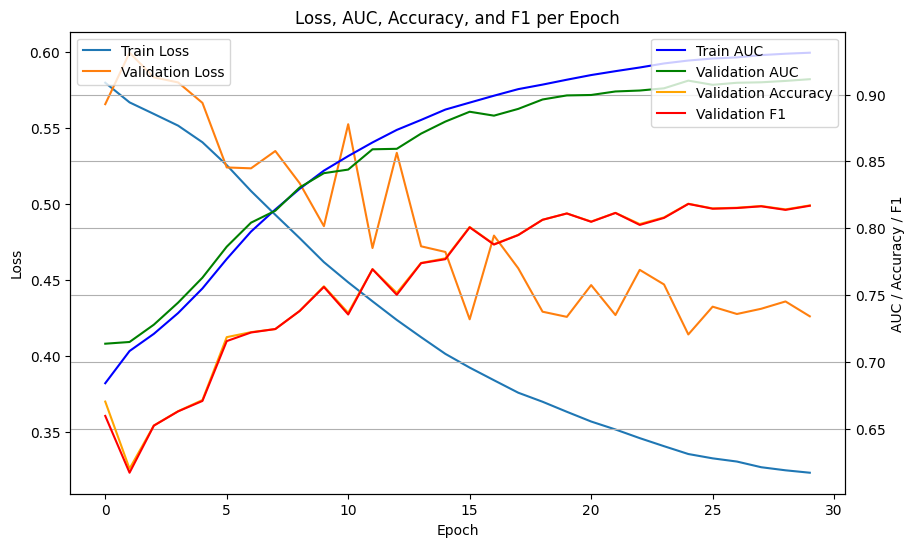

In [17]:
print(f"model_name: {model_name}")
print(f"Checkpoint directory: {checkpoint}")
print(f"learning_rate: {learning_rate}")

# 디바이스 재확인 및 모델 디바이스 이동
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
print(f"Using device: {device}")

# train_model 호출
train_model(
    model,
    model_name,
    tokenizer,
    train_loader,
    val_loader,
    num_epochs,
    learning_rate,
    checkpoint
)

In [15]:
def predict(model, loader, device):
    model.eval()
    preds, probs = [], []
    bar = tqdm(loader, desc="Predicting", leave=False)
    with torch.no_grad():
        for batch in bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            logits = outputs.logits
            prob = F.softmax(logits, dim=1)[:, 1]  # positive 확률

            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            probs.extend(prob.detach().float().cpu().numpy())  # bfloat16 → float32로 변환 후 numpy
    return preds, probs

In [16]:
class TestDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=512):
        self.data = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.loc[idx]
        text = item['paragraph_text']
        title = item['title']  # NEW: title 정보 가져오기
        
        text = clean_text(text)

        # 불용어 제거
        text = remove_stopwords_morph(text)
        
        combined_text = f"[TITLE] {title} [SEP] {text}"  # NEW: 타이틀과 본문 결합

        encoding = self.tokenizer(
            combined_text,  # NEW: combined_text로 토큰화
            add_special_tokens=True,
            max_length=self.max_length,
            truncation=True,
            padding='max_length',
            return_tensors="pt"
        )
        return {
            'input_ids':      encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze()
        }


In [17]:
test_df = pd.read_csv(test_csv)
test_dataset  = TestDataset(test_df, tokenizer, max_length=max_length)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [18]:
from peft import PeftModel, PeftConfig
from transformers import AutoModelForSequenceClassification, AutoTokenizer

def load_lora_model(adapter_path, torch_dtype=None):
    """
    LoRA adapter 경로로부터 base model과 tokenizer를 로드하고,
    LoRA adapter를 적용한 모델과 tokenizer 반환.

    Args:
        adapter_path (str): 저장된 LoRA adapter 디렉토리 경로
        torch_dtype (torch.dtype, optional): 모델 로드 시 사용할 dtype (예: torch.bfloat16)

    Returns:
        model (PeftModel): LoRA adapter가 적용된 모델
        tokenizer (AutoTokenizer): 저장된 tokenizer
    """
    # 1. adapter config 로드
    peft_config = PeftConfig.from_pretrained(adapter_path, local_files_only=True)

    # 2. base model 로드
    base_model = AutoModelForSequenceClassification.from_pretrained(
        peft_config.base_model_name_or_path,
        torch_dtype=torch_dtype
    )
    base_model.config.pad_token_id = base_model.config.eos_token_id

    # 3. LoRA adapter 적용
    model = PeftModel.from_pretrained(base_model, adapter_path)

    # 4. tokenizer 로드 (같은 adapter_path에서)
    tokenizer = AutoTokenizer.from_pretrained(adapter_path, use_fast=True)

    return model, tokenizer


In [19]:
load_path = f"{checkpoint}/best_model"
model, tokenizer = load_lora_model(load_path, torch_dtype=torch.bfloat16)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

pred_labels, pred_probs = predict(model, test_loader, device)

sample_submission = pd.read_csv('/home/work/.datasets/sample_submission.csv', encoding='utf-8-sig')

# 확률로 저장
sample_submission_probs = sample_submission.copy()
sample_submission_probs['generated'] = pred_probs

# 저장 디렉토리
output_dir = f"/home/work/hhg/{checkpoint}"

output_path = os.path.join(output_dir, f"{checkpoint}_best.csv")
sample_submission_probs.to_csv(output_path, index=False)

print(f"파일이 저장되었습니다: {output_path}")


Predicting:   0%|          | 0/62 [00:00<?, ?it/s]

파일이 저장되었습니다: /home/work/hhg/stopword_okt/stopword_okt_best.csv
